In [1]:
# Copyright (c) 2023-2024 Pietro Luca Mazzacuva <pietroluca.mazzacuva@unicampus.it>
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.platform.tf_logging import warn
from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.models import load_model
from glob import glob
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from REDInet import Utils, TCN

base_inputdir_path = "/lustre/home/pietrolucamazzacuva"

model_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models"
if not os.path.exists(model_path):
    os.mkdir(model_path)

model_name = f'REDInet_log_preprocessing_pos_zeros_snps_{datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}.h5'

body_site_table = pd.read_table("/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/SRR_list.tsv")

features_total_filepaths = []
metadata_total_filepaths = []

for c,srr in enumerate(body_site_table["Sample"].tolist()):
    print(f"[{datetime.now()}] Loading SRR {srr} features vectors and metadata.")
    features_filepath = glob(os.path.join(base_inputdir_path, "*", f"{srr}_features_reduced_pos_zeros_snps.tsv"))
    metadata_filepath = glob(os.path.join(base_inputdir_path, "*", f"{srr}_metadata_reduced_pos_zeros_snps.tsv"))
    features_total_filepaths += features_filepath
    metadata_total_filepaths += metadata_filepath
    
    
print(f"Total processed SRR table:", c+1)
print(f"Len. features_total_filepaths:", len(features_total_filepaths))
print(f"Len. metadata_total_filepaths:", len(metadata_total_filepaths))

start = datetime.now()
X_list = []
with tqdm(total=len(features_total_filepaths)) as pbar:
    for features_filepath in features_total_filepaths:
        X_list.append(pd.read_table(features_filepath, header=None))
        pbar.update(1)
X = pd.concat(X_list, axis=0)
del(X_list)

y_list = []
with tqdm(total=len(metadata_total_filepaths)) as pbar:
    for metadata_filepath in metadata_total_filepaths:
        y_list.append(pd.read_table(metadata_filepath, sep="\t"))
        pbar.update(1)
y = pd.concat(y_list, axis=0)
del(y_list)
print(f"Elapsed time for dataset loading: {datetime.now()-start}")

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)


X_3d = Utils().from_2_to_3_dimensions(X, 8)
del X

print("X3d shape before duplicated removal:", X_3d.shape)
X_3d, indexes = np.unique(X_3d, axis=0, return_index=True)
print("X3d shape after duplicated removal:", X_3d.shape)
y = y.iloc[indexes, :]
print("y shape after duplicated removal:", y.shape)
y.reset_index(drop=True, inplace=True)

X_3d_log2 = Utils().log_preprocessing(X_3d)
del(X_3d)


X_train, X_test, y_train, y_test = train_test_split(X_3d_log2, y, random_state=42, shuffle=True, test_size=0.3)
X_test, X_val,  y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
del X_3d_log2, y

print("X train shape:", X_train.shape, flush=True)
print("y_train shape:", y_train.shape, flush=True)
print("X val shape:", X_val.shape, flush=True)
print("y_val shape:", y_val.shape, flush=True)
print("X_test shape", X_test.shape, flush=True)
print("y test shape:", y_test.shape, flush=True)

y_train_le = np.reshape(np.array([1 if (i.find("POSITIVE")!=-1) else 0 for i in y_train.iloc[:,4].values]), (y_train.shape[0],))
y_val_le = np.reshape(np.array([1 if (i.find("POSITIVE")!=-1) else 0 for i in y_val.iloc[:,4].values]), (y_val.shape[0],))
y_test_le = np.reshape(np.array([1 if (i.find("POSITIVE")!=-1) else 0 for i in y_test.iloc[:,4].values]), (y_test.shape[0],))



2024-04-15 10:07:41.166413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 10:07:54.379009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-15 10:07:54.379125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-15 10:07:54.379135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

[2024-04-15 10:08:19.296660] Loading SRR SRR1433410 features vectors and metadata.
[2024-04-15 10:08:19.372562] Loading SRR SRR1433555 features vectors and metadata.
[2024-04-15 10:08:19.386614] Loading SRR SRR1433926 features vectors and metadata.
[2024-04-15 10:08:19.389371] Loading SRR SRR1433950 features vectors and metadata.
[2024-04-15 10:08:19.399576] Loading SRR SRR1434712 features vectors and metadata.
[2024-04-15 10:08:19.400911] Loading SRR SRR1435229 features vectors and metadata.
[2024-04-15 10:08:19.402815] Loading SRR SRR1437119 features vectors and metadata.
[2024-04-15 10:08:19.404146] Loading SRR SRR1437390 features vectors and metadata.
[2024-04-15 10:08:19.405451] Loading SRR SRR1437622 features vectors and metadata.
[2024-04-15 10:08:19.407451] Loading SRR SRR1440161 features vectors and metadata.
[2024-04-15 10:08:19.408792] Loading SRR SRR1440898 features vectors and metadata.
[2024-04-15 10:08:19.413323] Loading SRR SRR1441159 features vectors and metadata.
[202

[2024-04-15 10:08:19.700319] Loading SRR SRR661313 features vectors and metadata.
[2024-04-15 10:08:19.703002] Loading SRR SRR661481 features vectors and metadata.
[2024-04-15 10:08:19.704285] Loading SRR SRR661589 features vectors and metadata.
[2024-04-15 10:08:19.705605] Loading SRR SRR661651 features vectors and metadata.
[2024-04-15 10:08:19.708098] Loading SRR SRR661699 features vectors and metadata.
[2024-04-15 10:08:19.709420] Loading SRR SRR661735 features vectors and metadata.
[2024-04-15 10:08:19.710756] Loading SRR SRR662103 features vectors and metadata.
[2024-04-15 10:08:19.712047] Loading SRR SRR662114 features vectors and metadata.
[2024-04-15 10:08:19.713371] Loading SRR SRR662186 features vectors and metadata.
[2024-04-15 10:08:19.714670] Loading SRR SRR663076 features vectors and metadata.
[2024-04-15 10:08:19.716005] Loading SRR SRR663197 features vectors and metadata.
[2024-04-15 10:08:19.717950] Loading SRR SRR663440 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:19.902049] Loading SRR SRR1432629 features vectors and metadata.
[2024-04-15 10:08:19.903420] Loading SRR SRR1433004 features vectors and metadata.
[2024-04-15 10:08:19.904754] Loading SRR SRR1433193 features vectors and metadata.
[2024-04-15 10:08:19.906025] Loading SRR SRR1433232 features vectors and metadata.
[2024-04-15 10:08:19.907318] Loading SRR SRR1433392 features vectors and metadata.
[2024-04-15 10:08:19.908605] Loading SRR SRR1328845 features vectors and metadata.
[2024-04-15 10:08:19.909885] Loading SRR SRR1329027 features vectors and metadata.
[2024-04-15 10:08:19.912039] Loading SRR SRR1330588 features vectors and metadata.
[2024-04-15 10:08:19.913329] Loading SRR SRR1330920 features vectors and metadata.
[2024-04-15 10:08:19.914718] Loading SRR SRR1332069 features vectors and metadata.
[2024-04-15 10:08:19.916144] Loading SRR SRR1332424 features vectors and metadata.
[2024-04-15 10:08:19.917574] Loading SRR SRR1332648 features vectors and metadata.
[202

[2024-04-15 10:08:20.103757] Loading SRR SRR1398074 features vectors and metadata.
[2024-04-15 10:08:20.105357] Loading SRR SRR1398924 features vectors and metadata.
[2024-04-15 10:08:20.107681] Loading SRR SRR1399797 features vectors and metadata.
[2024-04-15 10:08:20.109032] Loading SRR SRR1399971 features vectors and metadata.
[2024-04-15 10:08:20.110310] Loading SRR SRR1400202 features vectors and metadata.
[2024-04-15 10:08:20.111639] Loading SRR SRR1400847 features vectors and metadata.
[2024-04-15 10:08:20.113820] Loading SRR SRR1400910 features vectors and metadata.
[2024-04-15 10:08:20.115173] Loading SRR SRR1400974 features vectors and metadata.
[2024-04-15 10:08:20.116466] Loading SRR SRR1401211 features vectors and metadata.
[2024-04-15 10:08:20.117698] Loading SRR SRR1401252 features vectors and metadata.
[2024-04-15 10:08:20.118931] Loading SRR SRR1401990 features vectors and metadata.
[2024-04-15 10:08:20.121071] Loading SRR SRR1402962 features vectors and metadata.
[202

[2024-04-15 10:08:20.307109] Loading SRR SRR1322683 features vectors and metadata.
[2024-04-15 10:08:20.308568] Loading SRR SRR1323360 features vectors and metadata.
[2024-04-15 10:08:20.309901] Loading SRR SRR1325752 features vectors and metadata.
[2024-04-15 10:08:20.311320] Loading SRR SRR1327723 features vectors and metadata.
[2024-04-15 10:08:20.313647] Loading SRR SRR1329811 features vectors and metadata.
[2024-04-15 10:08:20.315075] Loading SRR SRR1331198 features vectors and metadata.
[2024-04-15 10:08:20.316492] Loading SRR SRR1331900 features vectors and metadata.
[2024-04-15 10:08:20.318968] Loading SRR SRR1332403 features vectors and metadata.
[2024-04-15 10:08:20.320315] Loading SRR SRR1333263 features vectors and metadata.
[2024-04-15 10:08:20.321554] Loading SRR SRR1337666 features vectors and metadata.
[2024-04-15 10:08:20.322965] Loading SRR SRR1341650 features vectors and metadata.
[2024-04-15 10:08:20.324417] Loading SRR SRR1341854 features vectors and metadata.
[202

[2024-04-15 10:08:20.509243] Loading SRR SRR602034 features vectors and metadata.
[2024-04-15 10:08:20.510783] Loading SRR SRR602564 features vectors and metadata.
[2024-04-15 10:08:20.512218] Loading SRR SRR602784 features vectors and metadata.
[2024-04-15 10:08:20.514543] Loading SRR SRR603140 features vectors and metadata.
[2024-04-15 10:08:20.515993] Loading SRR SRR603421 features vectors and metadata.
[2024-04-15 10:08:20.517433] Loading SRR SRR603472 features vectors and metadata.
[2024-04-15 10:08:20.518763] Loading SRR SRR603496 features vectors and metadata.
[2024-04-15 10:08:20.520089] Loading SRR SRR603566 features vectors and metadata.
[2024-04-15 10:08:20.521369] Loading SRR SRR603690 features vectors and metadata.
[2024-04-15 10:08:20.522651] Loading SRR SRR603890 features vectors and metadata.
[2024-04-15 10:08:20.524866] Loading SRR SRR604002 features vectors and metadata.
[2024-04-15 10:08:20.526303] Loading SRR SRR604718 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:20.710328] Loading SRR SRR1354665 features vectors and metadata.
[2024-04-15 10:08:20.712888] Loading SRR SRR1355102 features vectors and metadata.
[2024-04-15 10:08:20.714212] Loading SRR SRR1355451 features vectors and metadata.
[2024-04-15 10:08:20.715560] Loading SRR SRR1356248 features vectors and metadata.
[2024-04-15 10:08:20.716885] Loading SRR SRR1356397 features vectors and metadata.
[2024-04-15 10:08:20.719143] Loading SRR SRR1356553 features vectors and metadata.
[2024-04-15 10:08:20.720558] Loading SRR SRR1357103 features vectors and metadata.
[2024-04-15 10:08:20.721975] Loading SRR SRR1357757 features vectors and metadata.
[2024-04-15 10:08:20.723316] Loading SRR SRR1358343 features vectors and metadata.
[2024-04-15 10:08:20.724668] Loading SRR SRR1358713 features vectors and metadata.
[2024-04-15 10:08:20.726025] Loading SRR SRR1359280 features vectors and metadata.
[2024-04-15 10:08:20.727347] Loading SRR SRR1360080 features vectors and metadata.
[202

[2024-04-15 10:08:20.912098] Loading SRR SRR1336263 features vectors and metadata.
[2024-04-15 10:08:20.913526] Loading SRR SRR1336706 features vectors and metadata.
[2024-04-15 10:08:20.914785] Loading SRR SRR1337540 features vectors and metadata.
[2024-04-15 10:08:20.916120] Loading SRR SRR1338055 features vectors and metadata.
[2024-04-15 10:08:20.917455] Loading SRR SRR1338536 features vectors and metadata.
[2024-04-15 10:08:20.918739] Loading SRR SRR1338648 features vectors and metadata.
[2024-04-15 10:08:20.920064] Loading SRR SRR1338880 features vectors and metadata.
[2024-04-15 10:08:20.921402] Loading SRR SRR1338942 features vectors and metadata.
[2024-04-15 10:08:20.923360] Loading SRR SRR1338964 features vectors and metadata.
[2024-04-15 10:08:20.924698] Loading SRR SRR1339619 features vectors and metadata.
[2024-04-15 10:08:20.925930] Loading SRR SRR1339856 features vectors and metadata.
[2024-04-15 10:08:20.927223] Loading SRR SRR1340804 features vectors and metadata.
[202

[2024-04-15 10:08:21.114631] Loading SRR SRR613723 features vectors and metadata.
[2024-04-15 10:08:21.117042] Loading SRR SRR613963 features vectors and metadata.
[2024-04-15 10:08:21.118287] Loading SRR SRR614011 features vectors and metadata.
[2024-04-15 10:08:21.119641] Loading SRR SRR614059 features vectors and metadata.
[2024-04-15 10:08:21.121756] Loading SRR SRR614131 features vectors and metadata.
[2024-04-15 10:08:21.123093] Loading SRR SRR614143 features vectors and metadata.
[2024-04-15 10:08:21.124525] Loading SRR SRR614167 features vectors and metadata.
[2024-04-15 10:08:21.125866] Loading SRR SRR614179 features vectors and metadata.
[2024-04-15 10:08:21.127280] Loading SRR SRR614311 features vectors and metadata.
[2024-04-15 10:08:21.128628] Loading SRR SRR614503 features vectors and metadata.
[2024-04-15 10:08:21.130946] Loading SRR SRR614527 features vectors and metadata.
[2024-04-15 10:08:21.132306] Loading SRR SRR614635 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:21.315658] Loading SRR SRR1396840 features vectors and metadata.
[2024-04-15 10:08:21.317126] Loading SRR SRR1396877 features vectors and metadata.
[2024-04-15 10:08:21.318495] Loading SRR SRR1397837 features vectors and metadata.
[2024-04-15 10:08:21.319774] Loading SRR SRR1397971 features vectors and metadata.
[2024-04-15 10:08:21.321750] Loading SRR SRR1398207 features vectors and metadata.
[2024-04-15 10:08:21.323061] Loading SRR SRR1398352 features vectors and metadata.
[2024-04-15 10:08:21.324346] Loading SRR SRR1398793 features vectors and metadata.
[2024-04-15 10:08:21.325679] Loading SRR SRR1399135 features vectors and metadata.
[2024-04-15 10:08:21.327001] Loading SRR SRR1399711 features vectors and metadata.
[2024-04-15 10:08:21.328274] Loading SRR SRR1399757 features vectors and metadata.
[2024-04-15 10:08:21.329613] Loading SRR SRR1399821 features vectors and metadata.
[2024-04-15 10:08:21.330886] Loading SRR SRR1399843 features vectors and metadata.
[202

[2024-04-15 10:08:21.517637] Loading SRR SRR1102443 features vectors and metadata.
[2024-04-15 10:08:21.519142] Loading SRR SRR1102680 features vectors and metadata.
[2024-04-15 10:08:21.521473] Loading SRR SRR1103092 features vectors and metadata.
[2024-04-15 10:08:21.522808] Loading SRR SRR1105320 features vectors and metadata.
[2024-04-15 10:08:21.524167] Loading SRR SRR1105344 features vectors and metadata.
[2024-04-15 10:08:21.526692] Loading SRR SRR1105463 features vectors and metadata.
[2024-04-15 10:08:21.528017] Loading SRR SRR1120318 features vectors and metadata.
[2024-04-15 10:08:21.529405] Loading SRR SRR1120384 features vectors and metadata.
[2024-04-15 10:08:21.530738] Loading SRR SRR1307997 features vectors and metadata.
[2024-04-15 10:08:21.532225] Loading SRR SRR1308086 features vectors and metadata.
[2024-04-15 10:08:21.533646] Loading SRR SRR1309382 features vectors and metadata.
[2024-04-15 10:08:21.535823] Loading SRR SRR1309403 features vectors and metadata.
[202

[2024-04-15 10:08:21.720359] Loading SRR SRR1445595 features vectors and metadata.
[2024-04-15 10:08:21.721739] Loading SRR SRR1445856 features vectors and metadata.
[2024-04-15 10:08:21.723763] Loading SRR SRR1446050 features vectors and metadata.
[2024-04-15 10:08:21.725091] Loading SRR SRR1446180 features vectors and metadata.
[2024-04-15 10:08:21.728130] Loading SRR SRR1446436 features vectors and metadata.
[2024-04-15 10:08:21.729462] Loading SRR SRR1446649 features vectors and metadata.
[2024-04-15 10:08:21.730694] Loading SRR SRR1447215 features vectors and metadata.
[2024-04-15 10:08:21.731971] Loading SRR SRR1447715 features vectors and metadata.
[2024-04-15 10:08:21.733344] Loading SRR SRR1447871 features vectors and metadata.
[2024-04-15 10:08:21.734746] Loading SRR SRR1448140 features vectors and metadata.
[2024-04-15 10:08:21.736065] Loading SRR SRR1451796 features vectors and metadata.
[2024-04-15 10:08:21.737399] Loading SRR SRR655756 features vectors and metadata.
[2024

[2024-04-15 10:08:21.921909] Loading SRR SRR1469570 features vectors and metadata.
[2024-04-15 10:08:21.923260] Loading SRR SRR1470603 features vectors and metadata.
[2024-04-15 10:08:21.924639] Loading SRR SRR1470727 features vectors and metadata.
[2024-04-15 10:08:21.925915] Loading SRR SRR1470878 features vectors and metadata.
[2024-04-15 10:08:21.927234] Loading SRR SRR1470947 features vectors and metadata.
[2024-04-15 10:08:21.928595] Loading SRR SRR1471222 features vectors and metadata.
[2024-04-15 10:08:21.930943] Loading SRR SRR1471243 features vectors and metadata.
[2024-04-15 10:08:21.932260] Loading SRR SRR1471548 features vectors and metadata.
[2024-04-15 10:08:21.933594] Loading SRR SRR1471672 features vectors and metadata.
[2024-04-15 10:08:21.935924] Loading SRR SRR1472057 features vectors and metadata.
[2024-04-15 10:08:21.937261] Loading SRR SRR1472214 features vectors and metadata.
[2024-04-15 10:08:21.939816] Loading SRR SRR1472370 features vectors and metadata.
[202

[2024-04-15 10:08:22.123378] Loading SRR SRR1319485 features vectors and metadata.
[2024-04-15 10:08:22.126013] Loading SRR SRR1319520 features vectors and metadata.
[2024-04-15 10:08:22.127346] Loading SRR SRR1320424 features vectors and metadata.
[2024-04-15 10:08:22.128590] Loading SRR SRR1320827 features vectors and metadata.
[2024-04-15 10:08:22.129827] Loading SRR SRR1321011 features vectors and metadata.
[2024-04-15 10:08:22.131124] Loading SRR SRR1321165 features vectors and metadata.
[2024-04-15 10:08:22.132473] Loading SRR SRR1321570 features vectors and metadata.
[2024-04-15 10:08:22.133800] Loading SRR SRR1322643 features vectors and metadata.
[2024-04-15 10:08:22.135130] Loading SRR SRR1323252 features vectors and metadata.
[2024-04-15 10:08:22.136516] Loading SRR SRR1323271 features vectors and metadata.
[2024-04-15 10:08:22.137833] Loading SRR SRR1324269 features vectors and metadata.
[2024-04-15 10:08:22.139141] Loading SRR SRR1324349 features vectors and metadata.
[202

[2024-04-15 10:08:22.324765] Loading SRR SRR1429307 features vectors and metadata.
[2024-04-15 10:08:22.326326] Loading SRR SRR1429329 features vectors and metadata.
[2024-04-15 10:08:22.327646] Loading SRR SRR1429641 features vectors and metadata.
[2024-04-15 10:08:22.328983] Loading SRR SRR1429725 features vectors and metadata.
[2024-04-15 10:08:22.330267] Loading SRR SRR1429891 features vectors and metadata.
[2024-04-15 10:08:22.331560] Loading SRR SRR1429935 features vectors and metadata.
[2024-04-15 10:08:22.332885] Loading SRR SRR1429957 features vectors and metadata.
[2024-04-15 10:08:22.334168] Loading SRR SRR1430248 features vectors and metadata.
[2024-04-15 10:08:22.335474] Loading SRR SRR1430288 features vectors and metadata.
[2024-04-15 10:08:22.336808] Loading SRR SRR1430570 features vectors and metadata.
[2024-04-15 10:08:22.338106] Loading SRR SRR1430817 features vectors and metadata.
[2024-04-15 10:08:22.339455] Loading SRR SRR1430884 features vectors and metadata.
[202

[2024-04-15 10:08:22.527488] Loading SRR SRR1362060 features vectors and metadata.
[2024-04-15 10:08:22.528986] Loading SRR SRR1362183 features vectors and metadata.
[2024-04-15 10:08:22.531294] Loading SRR SRR1362219 features vectors and metadata.
[2024-04-15 10:08:22.532750] Loading SRR SRR817978 features vectors and metadata.
[2024-04-15 10:08:22.534105] Loading SRR SRR818033 features vectors and metadata.
[2024-04-15 10:08:22.535458] Loading SRR SRR818057 features vectors and metadata.
[2024-04-15 10:08:22.536809] Loading SRR SRR818086 features vectors and metadata.
[2024-04-15 10:08:22.538149] Loading SRR SRR818110 features vectors and metadata.
[2024-04-15 10:08:22.540587] Loading SRR SRR818146 features vectors and metadata.
[2024-04-15 10:08:22.542021] Loading SRR SRR818188 features vectors and metadata.
[2024-04-15 10:08:22.543461] Loading SRR SRR818210 features vectors and metadata.
[2024-04-15 10:08:22.544856] Loading SRR SRR818270 features vectors and metadata.
[2024-04-15 1

[2024-04-15 10:08:22.729041] Loading SRR SRR1388480 features vectors and metadata.
[2024-04-15 10:08:22.730530] Loading SRR SRR1388504 features vectors and metadata.
[2024-04-15 10:08:22.731924] Loading SRR SRR1389036 features vectors and metadata.
[2024-04-15 10:08:22.733275] Loading SRR SRR1389059 features vectors and metadata.
[2024-04-15 10:08:22.734650] Loading SRR SRR1389218 features vectors and metadata.
[2024-04-15 10:08:22.735990] Loading SRR SRR1389348 features vectors and metadata.
[2024-04-15 10:08:22.737323] Loading SRR SRR1389979 features vectors and metadata.
[2024-04-15 10:08:22.738672] Loading SRR SRR1390516 features vectors and metadata.
[2024-04-15 10:08:22.739996] Loading SRR SRR1390582 features vectors and metadata.
[2024-04-15 10:08:22.741321] Loading SRR SRR1390601 features vectors and metadata.
[2024-04-15 10:08:22.742675] Loading SRR SRR1391598 features vectors and metadata.
[2024-04-15 10:08:22.744013] Loading SRR SRR1391639 features vectors and metadata.
[202

[2024-04-15 10:08:22.931218] Loading SRR SRR1434271 features vectors and metadata.
[2024-04-15 10:08:22.932759] Loading SRR SRR1434484 features vectors and metadata.
[2024-04-15 10:08:22.934152] Loading SRR SRR1434526 features vectors and metadata.
[2024-04-15 10:08:22.935517] Loading SRR SRR1434803 features vectors and metadata.
[2024-04-15 10:08:22.936805] Loading SRR SRR1434867 features vectors and metadata.
[2024-04-15 10:08:22.939228] Loading SRR SRR1434934 features vectors and metadata.
[2024-04-15 10:08:22.940676] Loading SRR SRR1435020 features vectors and metadata.
[2024-04-15 10:08:22.943235] Loading SRR SRR1435484 features vectors and metadata.
[2024-04-15 10:08:22.944593] Loading SRR SRR1435536 features vectors and metadata.
[2024-04-15 10:08:22.946906] Loading SRR SRR1435884 features vectors and metadata.
[2024-04-15 10:08:22.948361] Loading SRR SRR1435901 features vectors and metadata.
[2024-04-15 10:08:22.950671] Loading SRR SRR1436106 features vectors and metadata.
[202

[2024-04-15 10:08:23.133174] Loading SRR SRR1320342 features vectors and metadata.
[2024-04-15 10:08:23.134667] Loading SRR SRR1320560 features vectors and metadata.
[2024-04-15 10:08:23.136811] Loading SRR SRR1320873 features vectors and metadata.
[2024-04-15 10:08:23.138122] Loading SRR SRR1320892 features vectors and metadata.
[2024-04-15 10:08:23.139460] Loading SRR SRR1320916 features vectors and metadata.
[2024-04-15 10:08:23.141623] Loading SRR SRR1320963 features vectors and metadata.
[2024-04-15 10:08:23.142896] Loading SRR SRR1321046 features vectors and metadata.
[2024-04-15 10:08:23.144181] Loading SRR SRR1321183 features vectors and metadata.
[2024-04-15 10:08:23.145440] Loading SRR SRR1321462 features vectors and metadata.
[2024-04-15 10:08:23.146751] Loading SRR SRR1321674 features vectors and metadata.
[2024-04-15 10:08:23.148062] Loading SRR SRR1321786 features vectors and metadata.
[2024-04-15 10:08:23.150320] Loading SRR SRR657325 features vectors and metadata.
[2024

[2024-04-15 10:08:23.334007] Loading SRR SRR612419 features vectors and metadata.
[2024-04-15 10:08:23.336148] Loading SRR SRR612443 features vectors and metadata.
[2024-04-15 10:08:23.337475] Loading SRR SRR612455 features vectors and metadata.
[2024-04-15 10:08:23.338760] Loading SRR SRR612563 features vectors and metadata.
[2024-04-15 10:08:23.340074] Loading SRR SRR612575 features vectors and metadata.
[2024-04-15 10:08:23.342797] Loading SRR SRR612623 features vectors and metadata.
[2024-04-15 10:08:23.344233] Loading SRR SRR612731 features vectors and metadata.
[2024-04-15 10:08:23.346547] Loading SRR SRR612899 features vectors and metadata.
[2024-04-15 10:08:23.347891] Loading SRR SRR613042 features vectors and metadata.
[2024-04-15 10:08:23.349326] Loading SRR SRR613090 features vectors and metadata.
[2024-04-15 10:08:23.351764] Loading SRR SRR613114 features vectors and metadata.
[2024-04-15 10:08:23.353206] Loading SRR SRR613270 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:23.535540] Loading SRR SRR603658 features vectors and metadata.
[2024-04-15 10:08:23.537083] Loading SRR SRR604026 features vectors and metadata.
[2024-04-15 10:08:23.538531] Loading SRR SRR604050 features vectors and metadata.
[2024-04-15 10:08:23.540860] Loading SRR SRR604074 features vectors and metadata.
[2024-04-15 10:08:23.542298] Loading SRR SRR604098 features vectors and metadata.
[2024-04-15 10:08:23.543756] Loading SRR SRR604146 features vectors and metadata.
[2024-04-15 10:08:23.545198] Loading SRR SRR604262 features vectors and metadata.
[2024-04-15 10:08:23.546535] Loading SRR SRR604318 features vectors and metadata.
[2024-04-15 10:08:23.547818] Loading SRR SRR604366 features vectors and metadata.
[2024-04-15 10:08:23.549156] Loading SRR SRR604456 features vectors and metadata.
[2024-04-15 10:08:23.551539] Loading SRR SRR607091 features vectors and metadata.
[2024-04-15 10:08:23.552885] Loading SRR SRR607141 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:23.736828] Loading SRR SRR1403831 features vectors and metadata.
[2024-04-15 10:08:23.738291] Loading SRR SRR1403875 features vectors and metadata.
[2024-04-15 10:08:23.739556] Loading SRR SRR1403915 features vectors and metadata.
[2024-04-15 10:08:23.740905] Loading SRR SRR1404168 features vectors and metadata.
[2024-04-15 10:08:23.742239] Loading SRR SRR1404601 features vectors and metadata.
[2024-04-15 10:08:23.744553] Loading SRR SRR1404640 features vectors and metadata.
[2024-04-15 10:08:23.745919] Loading SRR SRR1404969 features vectors and metadata.
[2024-04-15 10:08:23.747272] Loading SRR SRR1405007 features vectors and metadata.
[2024-04-15 10:08:23.748535] Loading SRR SRR1405224 features vectors and metadata.
[2024-04-15 10:08:23.749795] Loading SRR SRR1405485 features vectors and metadata.
[2024-04-15 10:08:23.751183] Loading SRR SRR1406561 features vectors and metadata.
[2024-04-15 10:08:23.752642] Loading SRR SRR1406917 features vectors and metadata.
[202

[2024-04-15 10:08:23.938601] Loading SRR SRR1456514 features vectors and metadata.
[2024-04-15 10:08:23.940040] Loading SRR SRR1456531 features vectors and metadata.
[2024-04-15 10:08:23.941328] Loading SRR SRR1456841 features vectors and metadata.
[2024-04-15 10:08:23.942654] Loading SRR SRR1456903 features vectors and metadata.
[2024-04-15 10:08:23.943970] Loading SRR SRR1456950 features vectors and metadata.
[2024-04-15 10:08:23.945296] Loading SRR SRR1457221 features vectors and metadata.
[2024-04-15 10:08:23.946614] Loading SRR SRR1440119 features vectors and metadata.
[2024-04-15 10:08:23.947938] Loading SRR SRR1440246 features vectors and metadata.
[2024-04-15 10:08:23.949250] Loading SRR SRR1440308 features vectors and metadata.
[2024-04-15 10:08:23.950570] Loading SRR SRR1440356 features vectors and metadata.
[2024-04-15 10:08:23.951872] Loading SRR SRR1440517 features vectors and metadata.
[2024-04-15 10:08:23.954151] Loading SRR SRR1440699 features vectors and metadata.
[202

[2024-04-15 10:08:24.139699] Loading SRR SRR1407648 features vectors and metadata.
[2024-04-15 10:08:24.141887] Loading SRR SRR1408014 features vectors and metadata.
[2024-04-15 10:08:24.143262] Loading SRR SRR1408574 features vectors and metadata.
[2024-04-15 10:08:24.144612] Loading SRR SRR1409397 features vectors and metadata.
[2024-04-15 10:08:24.145952] Loading SRR SRR1409421 features vectors and metadata.
[2024-04-15 10:08:24.147299] Loading SRR SRR1410765 features vectors and metadata.
[2024-04-15 10:08:24.148642] Loading SRR SRR1413392 features vectors and metadata.
[2024-04-15 10:08:24.149964] Loading SRR SRR1414661 features vectors and metadata.
[2024-04-15 10:08:24.151293] Loading SRR SRR1415257 features vectors and metadata.
[2024-04-15 10:08:24.153557] Loading SRR SRR1415420 features vectors and metadata.
[2024-04-15 10:08:24.154700] Loading SRR SRR1417422 features vectors and metadata.
[2024-04-15 10:08:24.155809] Loading SRR SRR1417725 features vectors and metadata.
[202

[2024-04-15 10:08:24.341308] Loading SRR SRR1314092 features vectors and metadata.
[2024-04-15 10:08:24.342750] Loading SRR SRR1317282 features vectors and metadata.
[2024-04-15 10:08:24.344110] Loading SRR SRR1318774 features vectors and metadata.
[2024-04-15 10:08:24.346406] Loading SRR SRR1322249 features vectors and metadata.
[2024-04-15 10:08:24.347693] Loading SRR SRR1323829 features vectors and metadata.
[2024-04-15 10:08:24.349822] Loading SRR SRR1324206 features vectors and metadata.
[2024-04-15 10:08:24.351925] Loading SRR SRR1327896 features vectors and metadata.
[2024-04-15 10:08:24.353233] Loading SRR SRR1328577 features vectors and metadata.
[2024-04-15 10:08:24.354587] Loading SRR SRR1328941 features vectors and metadata.
[2024-04-15 10:08:24.355908] Loading SRR SRR1331267 features vectors and metadata.
[2024-04-15 10:08:24.357190] Loading SRR SRR1075223 features vectors and metadata.
[2024-04-15 10:08:24.359310] Loading SRR SRR1077239 features vectors and metadata.
[202

[2024-04-15 10:08:24.543005] Loading SRR SRR1356976 features vectors and metadata.
[2024-04-15 10:08:24.544460] Loading SRR SRR1356997 features vectors and metadata.
[2024-04-15 10:08:24.545785] Loading SRR SRR1357456 features vectors and metadata.
[2024-04-15 10:08:24.547084] Loading SRR SRR1357692 features vectors and metadata.
[2024-04-15 10:08:24.548373] Loading SRR SRR1358624 features vectors and metadata.
[2024-04-15 10:08:24.549708] Loading SRR SRR1359509 features vectors and metadata.
[2024-04-15 10:08:24.551033] Loading SRR SRR1360194 features vectors and metadata.
[2024-04-15 10:08:24.552352] Loading SRR SRR1360258 features vectors and metadata.
[2024-04-15 10:08:24.553700] Loading SRR SRR1361883 features vectors and metadata.
[2024-04-15 10:08:24.555054] Loading SRR SRR1362514 features vectors and metadata.
[2024-04-15 10:08:24.557626] Loading SRR SRR1362664 features vectors and metadata.
[2024-04-15 10:08:24.558948] Loading SRR SRR1362928 features vectors and metadata.
[202

[2024-04-15 10:08:24.743664] Loading SRR SRR812721 features vectors and metadata.
[2024-04-15 10:08:24.745264] Loading SRR SRR813529 features vectors and metadata.
[2024-04-15 10:08:24.746593] Loading SRR SRR814108 features vectors and metadata.
[2024-04-15 10:08:24.747874] Loading SRR SRR816096 features vectors and metadata.
[2024-04-15 10:08:24.749242] Loading SRR SRR816794 features vectors and metadata.
[2024-04-15 10:08:24.751141] Loading SRR SRR818523 features vectors and metadata.
[2024-04-15 10:08:24.752483] Loading SRR SRR819486 features vectors and metadata.
[2024-04-15 10:08:24.753802] Loading SRR SRR1367785 features vectors and metadata.
[2024-04-15 10:08:24.755156] Loading SRR SRR1368094 features vectors and metadata.
[2024-04-15 10:08:24.756512] Loading SRR SRR1369008 features vectors and metadata.
[2024-04-15 10:08:24.757830] Loading SRR SRR1370107 features vectors and metadata.
[2024-04-15 10:08:24.759116] Loading SRR SRR1370701 features vectors and metadata.
[2024-04-15

[2024-04-15 10:08:24.944702] Loading SRR SRR1076964 features vectors and metadata.
[2024-04-15 10:08:24.946204] Loading SRR SRR1077310 features vectors and metadata.
[2024-04-15 10:08:24.947507] Loading SRR SRR1077356 features vectors and metadata.
[2024-04-15 10:08:24.948832] Loading SRR SRR1077575 features vectors and metadata.
[2024-04-15 10:08:24.950123] Loading SRR SRR1077599 features vectors and metadata.
[2024-04-15 10:08:24.951459] Loading SRR SRR1077619 features vectors and metadata.
[2024-04-15 10:08:24.953418] Loading SRR SRR1077850 features vectors and metadata.
[2024-04-15 10:08:24.954774] Loading SRR SRR1077874 features vectors and metadata.
[2024-04-15 10:08:24.956106] Loading SRR SRR1077992 features vectors and metadata.
[2024-04-15 10:08:24.957426] Loading SRR SRR1078140 features vectors and metadata.
[2024-04-15 10:08:24.958743] Loading SRR SRR1078368 features vectors and metadata.
[2024-04-15 10:08:24.960085] Loading SRR SRR1078514 features vectors and metadata.
[202

[2024-04-15 10:08:25.146274] Loading SRR SRR813505 features vectors and metadata.
[2024-04-15 10:08:25.148566] Loading SRR SRR813536 features vectors and metadata.
[2024-04-15 10:08:25.149883] Loading SRR SRR814003 features vectors and metadata.
[2024-04-15 10:08:25.151218] Loading SRR SRR814028 features vectors and metadata.
[2024-04-15 10:08:25.152554] Loading SRR SRR814219 features vectors and metadata.
[2024-04-15 10:08:25.153838] Loading SRR SRR814427 features vectors and metadata.
[2024-04-15 10:08:25.155185] Loading SRR SRR814447 features vectors and metadata.
[2024-04-15 10:08:25.156512] Loading SRR SRR814467 features vectors and metadata.
[2024-04-15 10:08:25.157845] Loading SRR SRR814515 features vectors and metadata.
[2024-04-15 10:08:25.159173] Loading SRR SRR814633 features vectors and metadata.
[2024-04-15 10:08:25.160507] Loading SRR SRR815116 features vectors and metadata.
[2024-04-15 10:08:25.161823] Loading SRR SRR815446 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:25.348394] Loading SRR SRR1325826 features vectors and metadata.
[2024-04-15 10:08:25.349878] Loading SRR SRR1326059 features vectors and metadata.
[2024-04-15 10:08:25.351222] Loading SRR SRR1326317 features vectors and metadata.
[2024-04-15 10:08:25.352570] Loading SRR SRR1326868 features vectors and metadata.
[2024-04-15 10:08:25.353905] Loading SRR SRR1327654 features vectors and metadata.
[2024-04-15 10:08:25.355245] Loading SRR SRR1327769 features vectors and metadata.
[2024-04-15 10:08:25.356566] Loading SRR SRR1328506 features vectors and metadata.
[2024-04-15 10:08:25.358888] Loading SRR SRR1464936 features vectors and metadata.
[2024-04-15 10:08:25.360198] Loading SRR SRR1465313 features vectors and metadata.
[2024-04-15 10:08:25.362332] Loading SRR SRR1465395 features vectors and metadata.
[2024-04-15 10:08:25.364634] Loading SRR SRR1465522 features vectors and metadata.
[2024-04-15 10:08:25.365941] Loading SRR SRR1465824 features vectors and metadata.
[202

[2024-04-15 10:08:25.550028] Loading SRR SRR1083848 features vectors and metadata.
[2024-04-15 10:08:25.552268] Loading SRR SRR1083939 features vectors and metadata.
[2024-04-15 10:08:25.553732] Loading SRR SRR1084032 features vectors and metadata.
[2024-04-15 10:08:25.555172] Loading SRR SRR1084393 features vectors and metadata.
[2024-04-15 10:08:25.557294] Loading SRR SRR1084529 features vectors and metadata.
[2024-04-15 10:08:25.558613] Loading SRR SRR1084698 features vectors and metadata.
[2024-04-15 10:08:25.559909] Loading SRR SRR1084742 features vectors and metadata.
[2024-04-15 10:08:25.561214] Loading SRR SRR1084941 features vectors and metadata.
[2024-04-15 10:08:25.562528] Loading SRR SRR1085063 features vectors and metadata.
[2024-04-15 10:08:25.563821] Loading SRR SRR1085110 features vectors and metadata.
[2024-04-15 10:08:25.565085] Loading SRR SRR1085211 features vectors and metadata.
[2024-04-15 10:08:25.566363] Loading SRR SRR1085900 features vectors and metadata.
[202

[2024-04-15 10:08:25.751930] Loading SRR SRR1444222 features vectors and metadata.
[2024-04-15 10:08:25.753392] Loading SRR SRR1444436 features vectors and metadata.
[2024-04-15 10:08:25.754728] Loading SRR SRR1444598 features vectors and metadata.
[2024-04-15 10:08:25.756013] Loading SRR SRR1444808 features vectors and metadata.
[2024-04-15 10:08:25.757334] Loading SRR SRR1444830 features vectors and metadata.
[2024-04-15 10:08:25.758661] Loading SRR SRR1445023 features vectors and metadata.
[2024-04-15 10:08:25.760008] Loading SRR SRR1445387 features vectors and metadata.
[2024-04-15 10:08:25.761354] Loading SRR SRR1445573 features vectors and metadata.
[2024-04-15 10:08:25.762637] Loading SRR SRR1445701 features vectors and metadata.
[2024-04-15 10:08:25.763960] Loading SRR SRR1445813 features vectors and metadata.
[2024-04-15 10:08:25.765197] Loading SRR SRR1445984 features vectors and metadata.
[2024-04-15 10:08:25.766520] Loading SRR SRR1446308 features vectors and metadata.
[202

[2024-04-15 10:08:25.953058] Loading SRR SRR1383937 features vectors and metadata.
[2024-04-15 10:08:25.955699] Loading SRR SRR1384805 features vectors and metadata.
[2024-04-15 10:08:25.957828] Loading SRR SRR1384827 features vectors and metadata.
[2024-04-15 10:08:25.959153] Loading SRR SRR1384852 features vectors and metadata.
[2024-04-15 10:08:25.960481] Loading SRR SRR1384917 features vectors and metadata.
[2024-04-15 10:08:25.961790] Loading SRR SRR1385235 features vectors and metadata.
[2024-04-15 10:08:25.963135] Loading SRR SRR1385364 features vectors and metadata.
[2024-04-15 10:08:25.964465] Loading SRR SRR1385716 features vectors and metadata.
[2024-04-15 10:08:25.965748] Loading SRR SRR1387091 features vectors and metadata.
[2024-04-15 10:08:25.967073] Loading SRR SRR1387475 features vectors and metadata.
[2024-04-15 10:08:25.968415] Loading SRR SRR1387702 features vectors and metadata.
[2024-04-15 10:08:25.970435] Loading SRR SRR1388105 features vectors and metadata.
[202

[2024-04-15 10:08:26.154307] Loading SRR SRR820316 features vectors and metadata.
[2024-04-15 10:08:26.156647] Loading SRR SRR821183 features vectors and metadata.
[2024-04-15 10:08:26.157989] Loading SRR SRR604230 features vectors and metadata.
[2024-04-15 10:08:26.159302] Loading SRR SRR606939 features vectors and metadata.
[2024-04-15 10:08:26.160627] Loading SRR SRR607252 features vectors and metadata.
[2024-04-15 10:08:26.161939] Loading SRR SRR607313 features vectors and metadata.
[2024-04-15 10:08:26.163269] Loading SRR SRR607970 features vectors and metadata.
[2024-04-15 10:08:26.164593] Loading SRR SRR608096 features vectors and metadata.
[2024-04-15 10:08:26.165926] Loading SRR SRR612335 features vectors and metadata.
[2024-04-15 10:08:26.167320] Loading SRR SRR612719 features vectors and metadata.
[2024-04-15 10:08:26.169326] Loading SRR SRR612875 features vectors and metadata.
[2024-04-15 10:08:26.170605] Loading SRR SRR613186 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:26.355434] Loading SRR SRR1479286 features vectors and metadata.
[2024-04-15 10:08:26.357783] Loading SRR SRR1479933 features vectors and metadata.
[2024-04-15 10:08:26.359212] Loading SRR SRR1481012 features vectors and metadata.
[2024-04-15 10:08:26.360644] Loading SRR SRR1485078 features vectors and metadata.
[2024-04-15 10:08:26.362067] Loading SRR SRR1486174 features vectors and metadata.
[2024-04-15 10:08:26.363392] Loading SRR SRR1487233 features vectors and metadata.
[2024-04-15 10:08:26.365502] Loading SRR SRR1487425 features vectors and metadata.
[2024-04-15 10:08:26.366800] Loading SRR SRR1488632 features vectors and metadata.
[2024-04-15 10:08:26.368098] Loading SRR SRR1489693 features vectors and metadata.
[2024-04-15 10:08:26.369393] Loading SRR SRR1489715 features vectors and metadata.
[2024-04-15 10:08:26.370691] Loading SRR SRR1490076 features vectors and metadata.
[2024-04-15 10:08:26.371995] Loading SRR SRR1490289 features vectors and metadata.
[202

[2024-04-15 10:08:26.556400] Loading SRR SRR1456711 features vectors and metadata.
[2024-04-15 10:08:26.557826] Loading SRR SRR1465871 features vectors and metadata.
[2024-04-15 10:08:26.559158] Loading SRR SRR1468426 features vectors and metadata.
[2024-04-15 10:08:26.561517] Loading SRR SRR1469746 features vectors and metadata.
[2024-04-15 10:08:26.562844] Loading SRR SRR1490658 features vectors and metadata.
[2024-04-15 10:08:26.564162] Loading SRR SRR1500261 features vectors and metadata.
[2024-04-15 10:08:26.565520] Loading SRR SRR809943 features vectors and metadata.
[2024-04-15 10:08:26.566840] Loading SRR SRR1069141 features vectors and metadata.
[2024-04-15 10:08:26.569184] Loading SRR SRR1070689 features vectors and metadata.
[2024-04-15 10:08:26.570473] Loading SRR SRR1071668 features vectors and metadata.
[2024-04-15 10:08:26.571781] Loading SRR SRR1073435 features vectors and metadata.
[2024-04-15 10:08:26.573099] Loading SRR SRR1075102 features vectors and metadata.
[2024

[2024-04-15 10:08:26.757712] Loading SRR SRR1471989 features vectors and metadata.
[2024-04-15 10:08:26.759221] Loading SRR SRR1472462 features vectors and metadata.
[2024-04-15 10:08:26.760719] Loading SRR SRR1472885 features vectors and metadata.
[2024-04-15 10:08:26.762056] Loading SRR SRR1472952 features vectors and metadata.
[2024-04-15 10:08:26.763388] Loading SRR SRR1473161 features vectors and metadata.
[2024-04-15 10:08:26.764714] Loading SRR SRR1473340 features vectors and metadata.
[2024-04-15 10:08:26.767016] Loading SRR SRR1475524 features vectors and metadata.
[2024-04-15 10:08:26.768351] Loading SRR SRR1475546 features vectors and metadata.
[2024-04-15 10:08:26.769686] Loading SRR SRR1476719 features vectors and metadata.
[2024-04-15 10:08:26.771001] Loading SRR SRR1476927 features vectors and metadata.
[2024-04-15 10:08:26.772320] Loading SRR SRR1477797 features vectors and metadata.
[2024-04-15 10:08:26.773651] Loading SRR SRR1479155 features vectors and metadata.
[202

[2024-04-15 10:08:26.959627] Loading SRR SRR814244 features vectors and metadata.
[2024-04-15 10:08:26.961093] Loading SRR SRR814703 features vectors and metadata.
[2024-04-15 10:08:26.962432] Loading SRR SRR817166 features vectors and metadata.
[2024-04-15 10:08:26.964614] Loading SRR SRR817488 features vectors and metadata.
[2024-04-15 10:08:26.966052] Loading SRR SRR818499 features vectors and metadata.
[2024-04-15 10:08:26.967475] Loading SRR SRR819186 features vectors and metadata.
[2024-04-15 10:08:26.968887] Loading SRR SRR819658 features vectors and metadata.
[2024-04-15 10:08:26.970213] Loading SRR SRR820596 features vectors and metadata.
[2024-04-15 10:08:26.971533] Loading SRR SRR821302 features vectors and metadata.
[2024-04-15 10:08:26.972859] Loading SRR SRR821525 features vectors and metadata.
[2024-04-15 10:08:26.974210] Loading SRR SRR1414958 features vectors and metadata.
[2024-04-15 10:08:26.975663] Loading SRR SRR1415872 features vectors and metadata.
[2024-04-15 10

[2024-04-15 10:08:27.160471] Loading SRR SRR600784 features vectors and metadata.
[2024-04-15 10:08:27.161970] Loading SRR SRR600900 features vectors and metadata.
[2024-04-15 10:08:27.163298] Loading SRR SRR601311 features vectors and metadata.
[2024-04-15 10:08:27.164621] Loading SRR SRR601445 features vectors and metadata.
[2024-04-15 10:08:27.165935] Loading SRR SRR601477 features vectors and metadata.
[2024-04-15 10:08:27.167260] Loading SRR SRR601723 features vectors and metadata.
[2024-04-15 10:08:27.168574] Loading SRR SRR601925 features vectors and metadata.
[2024-04-15 10:08:27.169917] Loading SRR SRR602058 features vectors and metadata.
[2024-04-15 10:08:27.171223] Loading SRR SRR602492 features vectors and metadata.
[2024-04-15 10:08:27.172560] Loading SRR SRR602680 features vectors and metadata.
[2024-04-15 10:08:27.173892] Loading SRR SRR603004 features vectors and metadata.
[2024-04-15 10:08:27.175187] Loading SRR SRR603092 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:27.362468] Loading SRR SRR815783 features vectors and metadata.
[2024-04-15 10:08:27.363940] Loading SRR SRR815825 features vectors and metadata.
[2024-04-15 10:08:27.365255] Loading SRR SRR816015 features vectors and metadata.
[2024-04-15 10:08:27.366568] Loading SRR SRR816226 features vectors and metadata.
[2024-04-15 10:08:27.367888] Loading SRR SRR816382 features vectors and metadata.
[2024-04-15 10:08:27.370201] Loading SRR SRR817282 features vectors and metadata.
[2024-04-15 10:08:27.372196] Loading SRR SRR817421 features vectors and metadata.
[2024-04-15 10:08:27.373521] Loading SRR SRR818600 features vectors and metadata.
[2024-04-15 10:08:27.375766] Loading SRR SRR818773 features vectors and metadata.
[2024-04-15 10:08:27.377083] Loading SRR SRR818901 features vectors and metadata.
[2024-04-15 10:08:27.378402] Loading SRR SRR819054 features vectors and metadata.
[2024-04-15 10:08:27.379715] Loading SRR SRR819261 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:27.564511] Loading SRR SRR1402794 features vectors and metadata.
[2024-04-15 10:08:27.566103] Loading SRR SRR1403133 features vectors and metadata.
[2024-04-15 10:08:27.567529] Loading SRR SRR1403366 features vectors and metadata.
[2024-04-15 10:08:27.568911] Loading SRR SRR1404837 features vectors and metadata.
[2024-04-15 10:08:27.570208] Loading SRR SRR1405123 features vectors and metadata.
[2024-04-15 10:08:27.571541] Loading SRR SRR1405984 features vectors and metadata.
[2024-04-15 10:08:27.572864] Loading SRR SRR1406008 features vectors and metadata.
[2024-04-15 10:08:27.574186] Loading SRR SRR1406112 features vectors and metadata.
[2024-04-15 10:08:27.575553] Loading SRR SRR1408161 features vectors and metadata.
[2024-04-15 10:08:27.576867] Loading SRR SRR1408183 features vectors and metadata.
[2024-04-15 10:08:27.578182] Loading SRR SRR1408529 features vectors and metadata.
[2024-04-15 10:08:27.579501] Loading SRR SRR1408682 features vectors and metadata.
[202

[2024-04-15 10:08:27.766709] Loading SRR SRR1359780 features vectors and metadata.
[2024-04-15 10:08:27.768214] Loading SRR SRR1360402 features vectors and metadata.
[2024-04-15 10:08:27.769573] Loading SRR SRR1361480 features vectors and metadata.
[2024-04-15 10:08:27.770925] Loading SRR SRR1361546 features vectors and metadata.
[2024-04-15 10:08:27.772271] Loading SRR SRR1363908 features vectors and metadata.
[2024-04-15 10:08:27.773615] Loading SRR SRR1365034 features vectors and metadata.
[2024-04-15 10:08:27.774978] Loading SRR SRR1365426 features vectors and metadata.
[2024-04-15 10:08:27.776316] Loading SRR SRR1365448 features vectors and metadata.
[2024-04-15 10:08:27.777671] Loading SRR SRR1367109 features vectors and metadata.
[2024-04-15 10:08:27.779016] Loading SRR SRR1367715 features vectors and metadata.
[2024-04-15 10:08:27.781239] Loading SRR SRR1368072 features vectors and metadata.
[2024-04-15 10:08:27.782578] Loading SRR SRR1368117 features vectors and metadata.
[202

[2024-04-15 10:08:27.968824] Loading SRR SRR656385 features vectors and metadata.
[2024-04-15 10:08:27.970295] Loading SRR SRR656397 features vectors and metadata.
[2024-04-15 10:08:27.971620] Loading SRR SRR656770 features vectors and metadata.
[2024-04-15 10:08:27.972946] Loading SRR SRR656994 features vectors and metadata.
[2024-04-15 10:08:27.974220] Loading SRR SRR657540 features vectors and metadata.
[2024-04-15 10:08:27.975572] Loading SRR SRR657552 features vectors and metadata.
[2024-04-15 10:08:27.976895] Loading SRR SRR658164 features vectors and metadata.
[2024-04-15 10:08:27.978229] Loading SRR SRR1070086 features vectors and metadata.
[2024-04-15 10:08:27.980396] Loading SRR SRR1070159 features vectors and metadata.
[2024-04-15 10:08:27.981715] Loading SRR SRR1070597 features vectors and metadata.
[2024-04-15 10:08:27.983053] Loading SRR SRR1072724 features vectors and metadata.
[2024-04-15 10:08:27.984391] Loading SRR SRR1073553 features vectors and metadata.
[2024-04-15

[2024-04-15 10:08:28.170629] Loading SRR SRR1380829 features vectors and metadata.
[2024-04-15 10:08:28.172086] Loading SRR SRR1381459 features vectors and metadata.
[2024-04-15 10:08:28.173408] Loading SRR SRR1382912 features vectors and metadata.
[2024-04-15 10:08:28.174666] Loading SRR SRR1384883 features vectors and metadata.
[2024-04-15 10:08:28.175984] Loading SRR SRR1385190 features vectors and metadata.
[2024-04-15 10:08:28.177309] Loading SRR SRR1386797 features vectors and metadata.
[2024-04-15 10:08:28.178627] Loading SRR SRR1390561 features vectors and metadata.
[2024-04-15 10:08:28.179932] Loading SRR SRR1391660 features vectors and metadata.
[2024-04-15 10:08:28.181259] Loading SRR SRR1391901 features vectors and metadata.
[2024-04-15 10:08:28.182578] Loading SRR SRR1394776 features vectors and metadata.
[2024-04-15 10:08:28.183891] Loading SRR SRR1395720 features vectors and metadata.
[2024-04-15 10:08:28.185221] Loading SRR SRR1395891 features vectors and metadata.
[202

[2024-04-15 10:08:28.372599] Loading SRR SRR1398863 features vectors and metadata.
[2024-04-15 10:08:28.374047] Loading SRR SRR1401528 features vectors and metadata.
[2024-04-15 10:08:28.375399] Loading SRR SRR1402091 features vectors and metadata.
[2024-04-15 10:08:28.376720] Loading SRR SRR1403412 features vectors and metadata.
[2024-04-15 10:08:28.378032] Loading SRR SRR1403611 features vectors and metadata.
[2024-04-15 10:08:28.379354] Loading SRR SRR1404507 features vectors and metadata.
[2024-04-15 10:08:28.380676] Loading SRR SRR1404856 features vectors and metadata.
[2024-04-15 10:08:28.382682] Loading SRR SRR1407334 features vectors and metadata.
[2024-04-15 10:08:28.384011] Loading SRR SRR1409084 features vectors and metadata.
[2024-04-15 10:08:28.385329] Loading SRR SRR1414161 features vectors and metadata.
[2024-04-15 10:08:28.386646] Loading SRR SRR1414613 features vectors and metadata.
[2024-04-15 10:08:28.387965] Loading SRR SRR1415919 features vectors and metadata.
[202

[2024-04-15 10:08:28.573852] Loading SRR SRR1343967 features vectors and metadata.
[2024-04-15 10:08:28.575301] Loading SRR SRR1347959 features vectors and metadata.
[2024-04-15 10:08:28.577672] Loading SRR SRR1353461 features vectors and metadata.
[2024-04-15 10:08:28.580236] Loading SRR SRR1354338 features vectors and metadata.
[2024-04-15 10:08:28.581649] Loading SRR SRR1357541 features vectors and metadata.
[2024-04-15 10:08:28.583075] Loading SRR SRR1357618 features vectors and metadata.
[2024-04-15 10:08:28.584507] Loading SRR SRR1359694 features vectors and metadata.
[2024-04-15 10:08:28.586741] Loading SRR SRR1360766 features vectors and metadata.
[2024-04-15 10:08:28.588074] Loading SRR SRR1361692 features vectors and metadata.
[2024-04-15 10:08:28.589516] Loading SRR SRR1365743 features vectors and metadata.
[2024-04-15 10:08:28.590931] Loading SRR SRR1367630 features vectors and metadata.
[2024-04-15 10:08:28.593331] Loading SRR SRR1374373 features vectors and metadata.
[202

[2024-04-15 10:08:28.775016] Loading SRR SRR1500089 features vectors and metadata.
[2024-04-15 10:08:28.776460] Loading SRR SRR657809 features vectors and metadata.
[2024-04-15 10:08:28.778777] Loading SRR SRR661052 features vectors and metadata.
[2024-04-15 10:08:28.780102] Loading SRR SRR813108 features vectors and metadata.
[2024-04-15 10:08:28.781455] Loading SRR SRR815280 features vectors and metadata.
[2024-04-15 10:08:28.782770] Loading SRR SRR815542 features vectors and metadata.
[2024-04-15 10:08:28.784096] Loading SRR SRR816818 features vectors and metadata.
[2024-04-15 10:08:28.785431] Loading SRR SRR816969 features vectors and metadata.
[2024-04-15 10:08:28.786751] Loading SRR SRR820234 features vectors and metadata.
[2024-04-15 10:08:28.788076] Loading SRR SRR1340721 features vectors and metadata.
[2024-04-15 10:08:28.789410] Loading SRR SRR1340943 features vectors and metadata.
[2024-04-15 10:08:28.790733] Loading SRR SRR1344294 features vectors and metadata.
[2024-04-15 

[2024-04-15 10:08:28.976798] Loading SRR SRR1404339 features vectors and metadata.
[2024-04-15 10:08:28.978332] Loading SRR SRR1406135 features vectors and metadata.
[2024-04-15 10:08:28.979657] Loading SRR SRR1406348 features vectors and metadata.
[2024-04-15 10:08:28.980977] Loading SRR SRR1407044 features vectors and metadata.
[2024-04-15 10:08:28.982286] Loading SRR SRR1413307 features vectors and metadata.
[2024-04-15 10:08:28.983602] Loading SRR SRR1416141 features vectors and metadata.
[2024-04-15 10:08:28.984943] Loading SRR SRR1416188 features vectors and metadata.
[2024-04-15 10:08:28.986260] Loading SRR SRR1416841 features vectors and metadata.
[2024-04-15 10:08:28.987579] Loading SRR SRR1418225 features vectors and metadata.
[2024-04-15 10:08:28.989691] Loading SRR SRR1418473 features vectors and metadata.
[2024-04-15 10:08:28.991101] Loading SRR SRR1333528 features vectors and metadata.
[2024-04-15 10:08:28.992528] Loading SRR SRR1333789 features vectors and metadata.
[202

[2024-04-15 10:08:29.178435] Loading SRR SRR1070455 features vectors and metadata.
[2024-04-15 10:08:29.179991] Loading SRR SRR1070525 features vectors and metadata.
[2024-04-15 10:08:29.181325] Loading SRR SRR1070841 features vectors and metadata.
[2024-04-15 10:08:29.182657] Loading SRR SRR1070888 features vectors and metadata.
[2024-04-15 10:08:29.183965] Loading SRR SRR1070937 features vectors and metadata.
[2024-04-15 10:08:29.185282] Loading SRR SRR1071035 features vectors and metadata.
[2024-04-15 10:08:29.186603] Loading SRR SRR1071157 features vectors and metadata.
[2024-04-15 10:08:29.187913] Loading SRR SRR1071337 features vectors and metadata.
[2024-04-15 10:08:29.189234] Loading SRR SRR1071983 features vectors and metadata.
[2024-04-15 10:08:29.190565] Loading SRR SRR1072223 features vectors and metadata.
[2024-04-15 10:08:29.191884] Loading SRR SRR1072676 features vectors and metadata.
[2024-04-15 10:08:29.193225] Loading SRR SRR1072773 features vectors and metadata.
[202

[2024-04-15 10:08:29.380044] Loading SRR SRR1099236 features vectors and metadata.
[2024-04-15 10:08:29.381506] Loading SRR SRR1099720 features vectors and metadata.
[2024-04-15 10:08:29.382821] Loading SRR SRR1100540 features vectors and metadata.
[2024-04-15 10:08:29.384137] Loading SRR SRR1100656 features vectors and metadata.
[2024-04-15 10:08:29.385428] Loading SRR SRR1100703 features vectors and metadata.
[2024-04-15 10:08:29.386747] Loading SRR SRR1101015 features vectors and metadata.
[2024-04-15 10:08:29.388072] Loading SRR SRR1457267 features vectors and metadata.
[2024-04-15 10:08:29.389393] Loading SRR SRR1457619 features vectors and metadata.
[2024-04-15 10:08:29.390707] Loading SRR SRR1457994 features vectors and metadata.
[2024-04-15 10:08:29.392753] Loading SRR SRR1458662 features vectors and metadata.
[2024-04-15 10:08:29.394186] Loading SRR SRR1458890 features vectors and metadata.
[2024-04-15 10:08:29.395646] Loading SRR SRR1459256 features vectors and metadata.
[202

[2024-04-15 10:08:29.581413] Loading SRR SRR1431406 features vectors and metadata.
[2024-04-15 10:08:29.583071] Loading SRR SRR1431429 features vectors and metadata.
[2024-04-15 10:08:29.585432] Loading SRR SRR1431452 features vectors and metadata.
[2024-04-15 10:08:29.586852] Loading SRR SRR1431475 features vectors and metadata.
[2024-04-15 10:08:29.588285] Loading SRR SRR1431847 features vectors and metadata.
[2024-04-15 10:08:29.589713] Loading SRR SRR1431906 features vectors and metadata.
[2024-04-15 10:08:29.591129] Loading SRR SRR1431969 features vectors and metadata.
[2024-04-15 10:08:29.592559] Loading SRR SRR1432297 features vectors and metadata.
[2024-04-15 10:08:29.593988] Loading SRR SRR1432563 features vectors and metadata.
[2024-04-15 10:08:29.595433] Loading SRR SRR1432673 features vectors and metadata.
[2024-04-15 10:08:29.596854] Loading SRR SRR1432695 features vectors and metadata.
[2024-04-15 10:08:29.598295] Loading SRR SRR1433514 features vectors and metadata.
[202

[2024-04-15 10:08:29.783883] Loading SRR SRR1354247 features vectors and metadata.
[2024-04-15 10:08:29.785624] Loading SRR SRR1355328 features vectors and metadata.
[2024-04-15 10:08:29.787072] Loading SRR SRR1355432 features vectors and metadata.
[2024-04-15 10:08:29.788509] Loading SRR SRR1355684 features vectors and metadata.
[2024-04-15 10:08:29.789944] Loading SRR SRR1355723 features vectors and metadata.
[2024-04-15 10:08:29.791373] Loading SRR SRR1355968 features vectors and metadata.
[2024-04-15 10:08:29.792823] Loading SRR SRR1356142 features vectors and metadata.
[2024-04-15 10:08:29.794263] Loading SRR SRR1356164 features vectors and metadata.
[2024-04-15 10:08:29.796690] Loading SRR SRR1356227 features vectors and metadata.
[2024-04-15 10:08:29.798137] Loading SRR SRR1357127 features vectors and metadata.
[2024-04-15 10:08:29.799575] Loading SRR SRR1357256 features vectors and metadata.
[2024-04-15 10:08:29.801003] Loading SRR SRR1357595 features vectors and metadata.
[202

[2024-04-15 10:08:29.985052] Loading SRR SRR656922 features vectors and metadata.
[2024-04-15 10:08:29.986543] Loading SRR SRR657042 features vectors and metadata.
[2024-04-15 10:08:29.987852] Loading SRR SRR657384 features vectors and metadata.
[2024-04-15 10:08:29.989168] Loading SRR SRR657516 features vectors and metadata.
[2024-04-15 10:08:29.990481] Loading SRR SRR657575 features vectors and metadata.
[2024-04-15 10:08:29.991812] Loading SRR SRR657857 features vectors and metadata.
[2024-04-15 10:08:29.993139] Loading SRR SRR1075659 features vectors and metadata.
[2024-04-15 10:08:29.994504] Loading SRR SRR1075752 features vectors and metadata.
[2024-04-15 10:08:29.995860] Loading SRR SRR1075778 features vectors and metadata.
[2024-04-15 10:08:29.997174] Loading SRR SRR1075923 features vectors and metadata.
[2024-04-15 10:08:29.998514] Loading SRR SRR1076096 features vectors and metadata.
[2024-04-15 10:08:29.999838] Loading SRR SRR1076144 features vectors and metadata.
[2024-04-1

[2024-04-15 10:08:30.186881] Loading SRR SRR1384006 features vectors and metadata.
[2024-04-15 10:08:30.188350] Loading SRR SRR1384290 features vectors and metadata.
[2024-04-15 10:08:30.189684] Loading SRR SRR1384962 features vectors and metadata.
[2024-04-15 10:08:30.190997] Loading SRR SRR1384986 features vectors and metadata.
[2024-04-15 10:08:30.192320] Loading SRR SRR1385171 features vectors and metadata.
[2024-04-15 10:08:30.193649] Loading SRR SRR1385211 features vectors and metadata.
[2024-04-15 10:08:30.194982] Loading SRR SRR1385343 features vectors and metadata.
[2024-04-15 10:08:30.196303] Loading SRR SRR1385542 features vectors and metadata.
[2024-04-15 10:08:30.197632] Loading SRR SRR1386844 features vectors and metadata.
[2024-04-15 10:08:30.198954] Loading SRR SRR1389820 features vectors and metadata.
[2024-04-15 10:08:30.200272] Loading SRR SRR1390160 features vectors and metadata.
[2024-04-15 10:08:30.201597] Loading SRR SRR1391354 features vectors and metadata.
[202

[2024-04-15 10:08:30.388980] Loading SRR SRR1373879 features vectors and metadata.
[2024-04-15 10:08:30.390432] Loading SRR SRR1375549 features vectors and metadata.
[2024-04-15 10:08:30.391744] Loading SRR SRR1377756 features vectors and metadata.
[2024-04-15 10:08:30.393980] Loading SRR SRR1378045 features vectors and metadata.
[2024-04-15 10:08:30.395325] Loading SRR SRR1389522 features vectors and metadata.
[2024-04-15 10:08:30.396655] Loading SRR SRR1391553 features vectors and metadata.
[2024-04-15 10:08:30.397978] Loading SRR SRR1391961 features vectors and metadata.
[2024-04-15 10:08:30.399299] Loading SRR SRR1392861 features vectors and metadata.
[2024-04-15 10:08:30.401621] Loading SRR SRR1396227 features vectors and metadata.
[2024-04-15 10:08:30.402946] Loading SRR SRR1396765 features vectors and metadata.
[2024-04-15 10:08:30.404260] Loading SRR SRR1400775 features vectors and metadata.
[2024-04-15 10:08:30.405626] Loading SRR SRR1401933 features vectors and metadata.
[202

[2024-04-15 10:08:30.592267] Loading SRR SRR1072700 features vectors and metadata.
[2024-04-15 10:08:30.593746] Loading SRR SRR1072821 features vectors and metadata.
[2024-04-15 10:08:30.595083] Loading SRR SRR1072920 features vectors and metadata.
[2024-04-15 10:08:30.596414] Loading SRR SRR1073459 features vectors and metadata.
[2024-04-15 10:08:30.597746] Loading SRR SRR1074066 features vectors and metadata.
[2024-04-15 10:08:30.599077] Loading SRR SRR1075874 features vectors and metadata.
[2024-04-15 10:08:30.601527] Loading SRR SRR1076268 features vectors and metadata.
[2024-04-15 10:08:30.602918] Loading SRR SRR1076990 features vectors and metadata.
[2024-04-15 10:08:30.604327] Loading SRR SRR1078090 features vectors and metadata.
[2024-04-15 10:08:30.605747] Loading SRR SRR1078759 features vectors and metadata.
[2024-04-15 10:08:30.607060] Loading SRR SRR1079900 features vectors and metadata.
[2024-04-15 10:08:30.608375] Loading SRR SRR1080672 features vectors and metadata.
[202

[2024-04-15 10:08:30.793264] Loading SRR SRR1322334 features vectors and metadata.
[2024-04-15 10:08:30.794707] Loading SRR SRR1327327 features vectors and metadata.
[2024-04-15 10:08:30.796035] Loading SRR SRR1328125 features vectors and metadata.
[2024-04-15 10:08:30.797338] Loading SRR SRR1328821 features vectors and metadata.
[2024-04-15 10:08:30.798646] Loading SRR SRR1332733 features vectors and metadata.
[2024-04-15 10:08:30.799961] Loading SRR SRR1333370 features vectors and metadata.
[2024-04-15 10:08:30.801281] Loading SRR SRR1334762 features vectors and metadata.
[2024-04-15 10:08:30.803502] Loading SRR SRR1335338 features vectors and metadata.
[2024-04-15 10:08:30.804828] Loading SRR SRR1335536 features vectors and metadata.
[2024-04-15 10:08:30.806137] Loading SRR SRR1337052 features vectors and metadata.
[2024-04-15 10:08:30.807455] Loading SRR SRR1337977 features vectors and metadata.
[2024-04-15 10:08:30.808765] Loading SRR SRR1341142 features vectors and metadata.
[202

[2024-04-15 10:08:30.994477] Loading SRR SRR1083554 features vectors and metadata.
[2024-04-15 10:08:30.995949] Loading SRR SRR1084347 features vectors and metadata.
[2024-04-15 10:08:30.997288] Loading SRR SRR1087055 features vectors and metadata.
[2024-04-15 10:08:30.998609] Loading SRR SRR1087535 features vectors and metadata.
[2024-04-15 10:08:30.999928] Loading SRR SRR1088241 features vectors and metadata.
[2024-04-15 10:08:31.001264] Loading SRR SRR1089643 features vectors and metadata.
[2024-04-15 10:08:31.002587] Loading SRR SRR1090604 features vectors and metadata.
[2024-04-15 10:08:31.003906] Loading SRR SRR1090650 features vectors and metadata.
[2024-04-15 10:08:31.005246] Loading SRR SRR1090722 features vectors and metadata.
[2024-04-15 10:08:31.006574] Loading SRR SRR1092612 features vectors and metadata.
[2024-04-15 10:08:31.008981] Loading SRR SRR1094287 features vectors and metadata.
[2024-04-15 10:08:31.010410] Loading SRR SRR1095213 features vectors and metadata.
[202

[2024-04-15 10:08:31.196256] Loading SRR SRR614107 features vectors and metadata.
[2024-04-15 10:08:31.197709] Loading SRR SRR614275 features vectors and metadata.
[2024-04-15 10:08:31.199023] Loading SRR SRR614743 features vectors and metadata.
[2024-04-15 10:08:31.200329] Loading SRR SRR614912 features vectors and metadata.
[2024-04-15 10:08:31.201643] Loading SRR SRR615285 features vectors and metadata.
[2024-04-15 10:08:31.202941] Loading SRR SRR615347 features vectors and metadata.
[2024-04-15 10:08:31.204246] Loading SRR SRR615491 features vectors and metadata.
[2024-04-15 10:08:31.205594] Loading SRR SRR615886 features vectors and metadata.
[2024-04-15 10:08:31.206894] Loading SRR SRR654969 features vectors and metadata.
[2024-04-15 10:08:31.208210] Loading SRR SRR655076 features vectors and metadata.
[2024-04-15 10:08:31.209536] Loading SRR SRR655277 features vectors and metadata.
[2024-04-15 10:08:31.210836] Loading SRR SRR655495 features vectors and metadata.
[2024-04-15 10:0

[2024-04-15 10:08:31.397861] Loading SRR SRR1350566 features vectors and metadata.
[2024-04-15 10:08:31.399321] Loading SRR SRR1350588 features vectors and metadata.
[2024-04-15 10:08:31.400654] Loading SRR SRR1350936 features vectors and metadata.
[2024-04-15 10:08:31.401977] Loading SRR SRR1351257 features vectors and metadata.
[2024-04-15 10:08:31.403303] Loading SRR SRR1351624 features vectors and metadata.
[2024-04-15 10:08:31.404649] Loading SRR SRR1352001 features vectors and metadata.
[2024-04-15 10:08:31.405968] Loading SRR SRR1352575 features vectors and metadata.
[2024-04-15 10:08:31.407301] Loading SRR SRR1354225 features vectors and metadata.
[2024-04-15 10:08:31.408615] Loading SRR SRR1356120 features vectors and metadata.
[2024-04-15 10:08:31.409963] Loading SRR SRR1356308 features vectors and metadata.
[2024-04-15 10:08:31.411288] Loading SRR SRR1357344 features vectors and metadata.
[2024-04-15 10:08:31.413324] Loading SRR SRR1358459 features vectors and metadata.
[202

[2024-04-15 10:08:31.599770] Loading SRR SRR1397030 features vectors and metadata.
[2024-04-15 10:08:31.601215] Loading SRR SRR1397242 features vectors and metadata.
[2024-04-15 10:08:31.602566] Loading SRR SRR1401403 features vectors and metadata.
[2024-04-15 10:08:31.603887] Loading SRR SRR1401860 features vectors and metadata.
[2024-04-15 10:08:31.605223] Loading SRR SRR1406157 features vectors and metadata.
[2024-04-15 10:08:31.606554] Loading SRR SRR1409108 features vectors and metadata.
[2024-04-15 10:08:31.608710] Loading SRR SRR1410612 features vectors and metadata.
[2024-04-15 10:08:31.610129] Loading SRR SRR1414447 features vectors and metadata.
[2024-04-15 10:08:31.611556] Loading SRR SRR1415529 features vectors and metadata.
[2024-04-15 10:08:31.612929] Loading SRR SRR1416865 features vectors and metadata.
[2024-04-15 10:08:31.614281] Loading SRR SRR1417130 features vectors and metadata.
[2024-04-15 10:08:31.615704] Loading SRR SRR1417296 features vectors and metadata.
[202

100%|██████████| 8404/8404 [02:15<00:00, 61.80it/s] 


Elapsed time for dataset loading: 0:22:20.458541
X3d shape before duplicated removal: (12662255, 101, 8)
X3d shape after duplicated removal: (12532568, 101, 8)
y shape after duplicated removal: (12532568, 10)
X train shape: (8772797, 101, 8)
y_train shape: (8772797, 10)
X val shape: (1879886, 101, 8)
y_val shape: (1879886, 10)
X_test shape (1879885, 101, 8)
y test shape: (1879885, 10)


2024-04-15 10:57:30.592504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 10:57:31.201771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38249 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e1:00.0, compute capability: 8.0


Model: "REDInet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 REDInet_InputLayer (InputLa  [(None, 101, 8)]         0         
 yer)                                                            
                                                                 
 Conv1D (Conv1D)             (None, 101, 64)           1088      
                                                                 
 Residual_Units_Stack (Funct  (None, 101, 64)          547840    
 ional)                                                          
                                                                 
 MaxPooling_Block (Sequentia  (None, 4800)             99456     
 l)                                                              
                                                                 
 Multilayer_Perceptron (Sequ  (None, 1)                946369    
 ential)                                                   

2024-04-15 10:58:29.510069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302
2024-04-15 10:58:37.552279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17135/17135 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9976
Epoch 1: val_accuracy improved from -inf to 0.99915, saving model to /lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_15_04_2024_10_08_19.h5


2024-04-15 11:19:28.841548: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-15 11:19:28.841988: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


17135/17135 [==============================] - 1273s 73ms/step - loss: 0.0166 - accuracy: 0.9976 - val_loss: 0.0066 - val_accuracy: 0.9991
Epoch 2/50
17134/17135 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9993
Epoch 2: val_accuracy improved from 0.99915 to 0.99959, saving model to /lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_15_04_2024_10_08_19.h5
17135/17135 [==============================] - 1234s 72ms/step - loss: 0.0051 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9996
Epoch 3/50
17134/17135 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995
Epoch 3: val_accuracy improved from 0.99959 to 0.99961, saving model to /lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_15_04_2024_10_08_19.h5
17135/17135 [==============================] - 1252s 73ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.0022 - val_ac

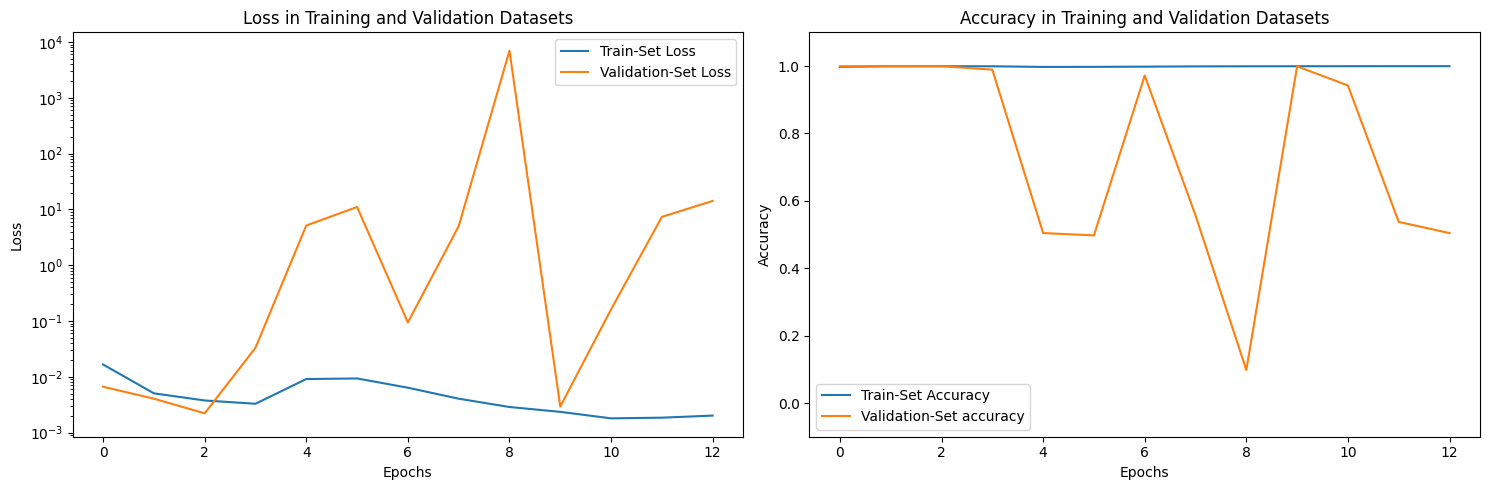

In [2]:
optimizer=Adam(learning_rate=0.001)
loss = BinaryCrossentropy(name="crossentropy")
train_metric = BinaryAccuracy(name="accuracy", threshold=0.5)
val_metric = "val_accuracy"
n_epoch = 50
batch_size = 512
patience = 10

model = TCN(input_shape=(101, 8), out_channels=64, max_rate=32, 
            up_out_channels=64, out_channels_mul = 3,  
            kernel_size=2, gain=1.0, l2=0.01, momentum=0.2, 
            epsilon=2e-5, strides=1, pool_size=2, n_units=10).get_model()


model.compile(loss=loss, optimizer=optimizer, metrics=[train_metric])
model.summary()

my_callbacks = [
                EarlyStopping(patience=patience,  monitor=val_metric),
                ModelCheckpoint(os.path.join(model_path, model_name),
                                monitor=val_metric, verbose=1,
                                save_best_only=True, mode='max')
               ]                

history = model.fit(X_train, y_train_le, epochs=n_epoch, batch_size=batch_size, verbose=1, callbacks=my_callbacks,
                   validation_data=(X_val, y_val_le), validation_batch_size=batch_size)

Utils().make_learning_curve(history, model_path, model_name)

del model, history
K.clear_session()

17135/17135 [==============================] - 380s 22ms/step


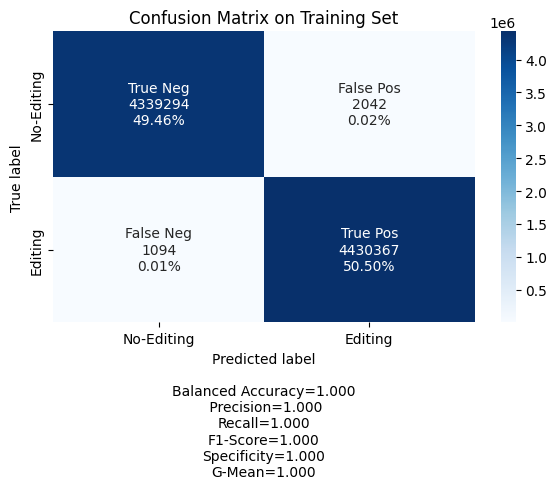

3672/3672 [==============================] - 82s 22ms/step


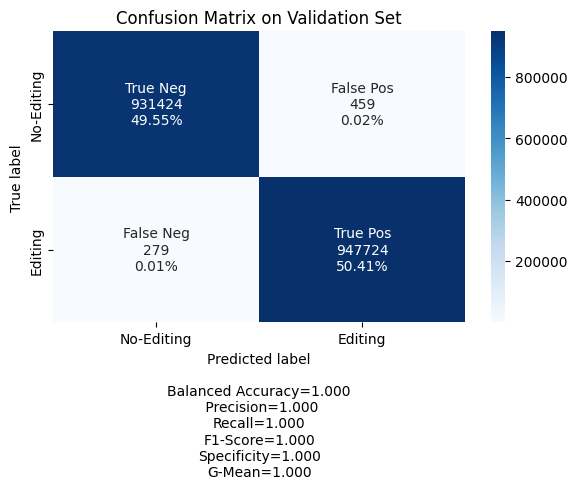

3672/3672 [==============================] - 82s 22ms/step


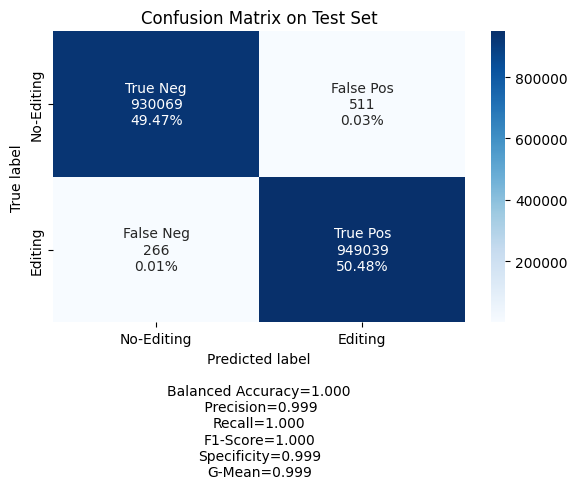

In [3]:
model = load_model(os.path.join(model_path, model_name))

y_train_hat = model.predict(X_train, verbose=1, batch_size=batch_size)
Utils().make_confusion_matrix(y_train_le,  y_train_hat,
                              title = "Confusion Matrix on Training Set",
                              figsize=(6,5),
                              path=os.path.join(model_path, f"{model_name}_Conf_Matrix_TRAIN.tiff"))

del X_train, y_train_le, y_train_hat
K.clear_session()

model = load_model(os.path.join(model_path, model_name))

y_val_hat = model.predict(X_val, verbose=1, batch_size=batch_size)
Utils().make_confusion_matrix(y_val_le,  y_val_hat,
                              title = "Confusion Matrix on Validation Set",
                              figsize=(6,5),
                              path=os.path.join(model_path, f"{model_name}_Conf_Matrix_VAL.tiff"))

del X_val, y_val_le, y_val_hat
K.clear_session()

model = load_model(os.path.join(model_path, model_name))

y_test_hat = model.predict(X_test, verbose=1, batch_size=batch_size)
Utils().make_confusion_matrix(y_test_le,  y_test_hat,
                              title = "Confusion Matrix on Test Set",
                              figsize=(6,5),
                              path=os.path.join(model_path, f"{model_name}_Conf_Matrix_TEST.tiff"))

del X_test, y_test_le, y_test_hat
K.clear_session()